# Using SFRmaker with NHDPlus High Resolution
This notebook demostrates how to use `sfrmaker` to build an SFR package with an NHDPlus HR file geodatabase (or set of file geodatabases) obtained from the USGS National Map download client. 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from shapely.geometry import box
from flopy.discretization import StructuredGrid
import geopandas as gpd
import sfrmaker


In [2]:
sfrmaker.__version__

'0.11.3.post36.dev0+g91a40ad'

In this demo, two HUC-4 file geodatabases (HUC0202 and HUC0204; each clipped to a reduced size) are used to make a single SFR network. NHDPlusHR networks for HUC-4 drainage basins are avaialble from the national map downloader as file geodatabases: https://apps.nationalmap.gov/downloader/#/

## 1. Preview NHDPlusHR geodatabases

In [3]:
NHDPlusHR_paths = ['../neversink_rondout/NHDPLUS_HR_1.gdb', '../neversink_rondout/NHDPLUS_HR_2.gdb']

# first NHDPlus HR file geodatabase -- derrived from a section of HUC_0202 for this demo
gdb1 = gpd.read_file(NHDPlusHR_paths[0], driver='OpenFileGDB', layer='NHDFlowline')

# seccond NHDPlus HR file geodatabase -- derrived from a section of HUC_0204 for this demo
gdb2 = gpd.read_file(NHDPlusHR_paths[1], driver='OpenFileGDB', layer='NHDFlowline')

### Plot the raw NHD HR lines from the two geodatabases

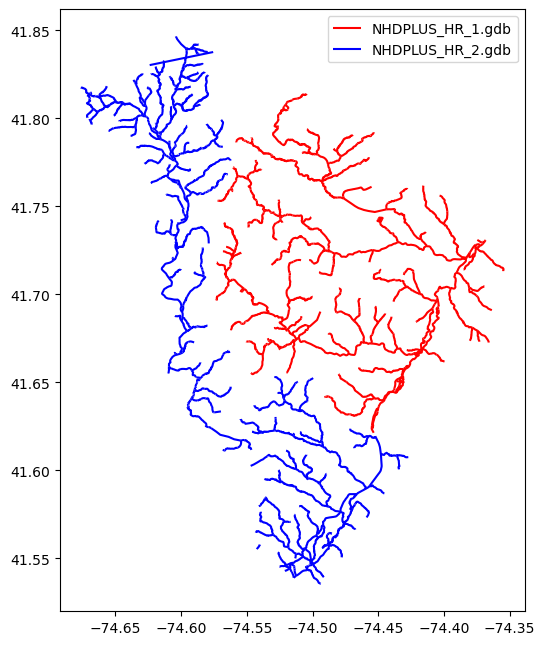

In [4]:
fig, ax = plt.subplots(figsize=(6,8))
gdb1.plot(ax=ax, color='red', label='NHDPLUS_HR_1.gdb')
gdb2.plot(ax=ax, color='blue', label='NHDPLUS_HR_2.gdb')
ax.legend()
plt.show()

#### Note: NHDPlusHR fileGDBs have EPSG:4269 CRS

In [5]:
assert gdb1.crs == gdb2.crs
nhdhr_epsg = gdb1.crs
print(nhdhr_epsg)

EPSG:4269


## 2. Filter network using shapefile boundary
The network can be filterd using a shapefile of the model domain

In [6]:
boundary_file = '../neversink_rondout/Model_Extent.shp'

model_boundary = gpd.read_file(boundary_file)

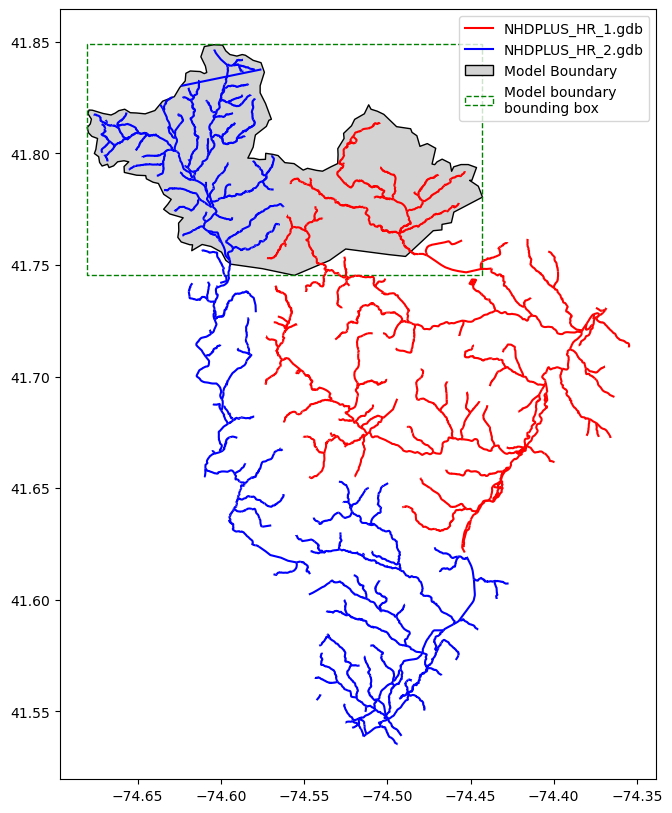

In [7]:
fig, ax = plt.subplots(figsize=(8,10))
gdb1.plot(ax=ax, color='red', label='NHDPLUS_HR_1.gdb')
gdb2.plot(ax=ax, color='blue', label='NHDPLUS_HR_2.gdb')
model_boundary.plot(ax=ax, facecolor='lightgray', edgecolor='black', label='Model Boundary') 

# plot boundary box that will be used for filtering
bbox_geometry = [box(x1, y1, x2, y2) for x1,y1,x2,y2 in model_boundary.bounds.values]
bbox = gpd.GeoDataFrame(geometry=bbox_geometry, crs=model_boundary.crs)
bbox.plot(ax=ax, facecolor='None', edgecolor='green', linestyle='--', label='Boundary bounding box')

LegendElement = [
    mpatches.mlines.Line2D([], [], color='red', label='NHDPLUS_HR_1.gdb'),
    mpatches.mlines.Line2D([], [], color='blue', label='NHDPLUS_HR_2.gdb'),
    mpatches.Patch(facecolor='lightgray', edgecolor='black', label='Model Boundary'),
    mpatches.Patch(facecolor='None', edgecolor='green', 
                   linestyle='--', label='Model boundary\nbounding box'),
]

ax.legend(handles=LegendElement, loc='best')
plt.show()

## 3. Option to remove reaches with unwated FCodes
NHDPlusHR flowlines include feature codes (FCodes) that describe reach attributes. In certain cases, a user may not wish to include certain types of features present in the NHDPlusHR geodatabase in the SFR network. A complete list of FCodes is show below:

![title](../_static/fcodes.png)

**Look at FCodes in `gdb2`**

In [8]:
gdb2.FCode.unique().astype(int).tolist()

[46006, 55800, 46003, 33600, 33400, 42803, 46000]

**We can remove any segments that have FCodes we don't want to include in the final SFR network**  
In this case, we want to exclude any lines classified as aqueduct pipelines.

In [9]:
drop_fcodes = [
    42803  # Aqueduct pipeline
]

gdb2.loc[gdb2.FCode.isin(drop_fcodes)]

,Permanent_,FDate,Resolution,GNIS_ID,GNIS_Name,LengthKM,ReachCode,FlowDir,WBArea_Per,FType,FCode,MainPath,InNetwork,Visibility,Shape_Leng,NHDPlusID,VPUID,Enabled,Shape_Length,geometry
78,149269353,2013-11-10T00:00:00+00:00,2.0,,,5.519868,02040104000515,1.0,,428.0,42803.0,0.0,1.0,0.0,0.063954,1.000020e+13,0204,1.0,0.04889,"MULTILINESTRING Z ((-74.62398 41.83019 0, -74...."


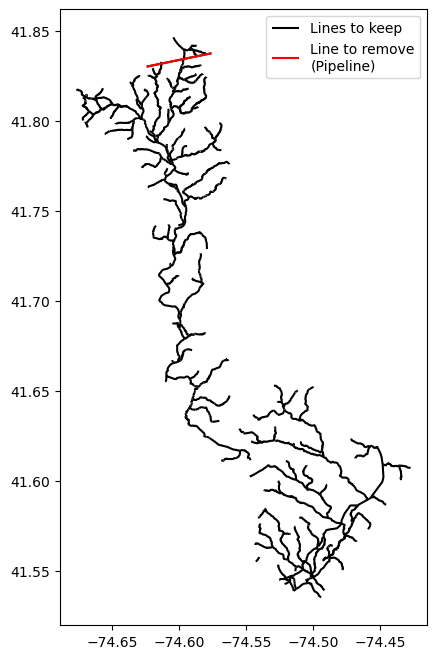

In [10]:
fig, ax = plt.subplots(figsize=(6,8))
gdb2.plot(ax=ax, color='black', zorder=0, label='Lines to keep')
gdb2.loc[gdb2.FCode.isin(drop_fcodes)].plot(ax=ax, color='red', zorder=1, label='Line to remove\n(Pipeline)')
ax.legend()
plt.show()

## 4. Make an `sfrmaker.lines` instance using `from_nhdplus_hr`

In [11]:
lines = sfrmaker.Lines.from_nhdplus_hr(NHDPlusHR_paths,
                                       bbox_filter=boundary_file,
                                       drop_fcodes=drop_fcodes,
                                       crs=4269
                                      )

loading NHDPlus HR hydrography data...
reading ../neversink_rondout/NHDPLUS_HR_1.gdb...
filtering flowlines...

Getting routing information from NHDPlus HR Plusflow table...
finished in 0.00s

finished in 0.08s

reading ../neversink_rondout/NHDPLUS_HR_2.gdb...
filtering flowlines...

Getting routing information from NHDPlus HR Plusflow table...
finished in 0.00s

finished in 0.05s


load finished in 0.14s



**Check out the `lines` DataFrame**

In [12]:
lines.df.head()

,id,toid,asum1,asum2,width1,width2,elevup,elevdn,name,geometry
0,10000700020952,10000700059483,0,12161.86061,0,0,303.83,303.83,West Branch Beer Kill,"MULTILINESTRING Z ((-74.53136 41.74642 0, -74...."
1,10000700020954,10000700020809,0,37.00000,0,0,371.90,371.65,,"MULTILINESTRING Z ((-74.53914 41.77121 0, -74...."
2,10000700020955,10000700069227,0,2521.00000,0,0,357.43,357.43,Beer Kill,"MULTILINESTRING Z ((-74.54092 41.78192 0, -74...."
3,10000700020956,10000700040140,0,6013.47549,0,0,340.63,331.49,Botsford Brook,"MULTILINESTRING Z ((-74.52677 41.79471 0, -74...."
4,10000700020968,10000700069232,0,3427.44672,0,0,350.75,350.75,Botsford Brook,"MULTILINESTRING Z ((-74.52519 41.80244 0, -74...."


### visualize the SFR network
The extent is limited to lines that intersect the bounding box of the supplied model boundary shapefile. Note: the aqueduct pipeline (highlighted above) in the north central part of the network was also removed.

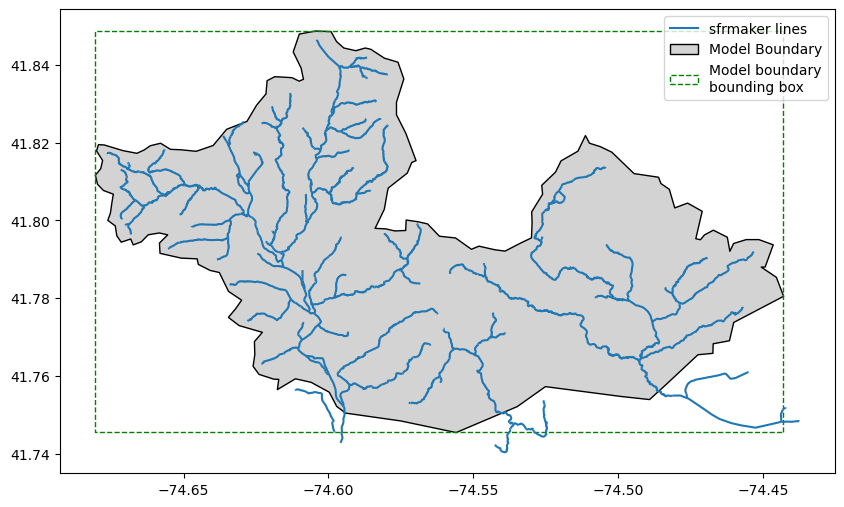

In [13]:
fig, ax = plt.subplots(figsize=(10,8))
lines.df.plot(ax=ax)
model_boundary.plot(ax=ax, facecolor='lightgray', edgecolor='black', label='Model Boundary') 

bbox.plot(ax=ax, facecolor='None', edgecolor='green', linestyle='--', label='Boundary bounding box')

LegendElement = [
    mpatches.mlines.Line2D([], [], color='#1f77b4', label='sfrmaker lines'),
    mpatches.Patch(facecolor='lightgray', edgecolor='black', label='Model Boundary'),
    mpatches.Patch(facecolor='None', edgecolor='green', 
                   linestyle='--', label='Model boundary\nbounding box'),
]

ax.legend(handles=LegendElement, loc='best')
plt.show()

## 5. Create a streamflow routing dataset and write an SFR package input file for MODDLOW

**This requires an `sfrmaker.lines` instance (created in step 4) and a `sfrmaker.grid` instance**  
we can start by building a synthetic Flopy strucutred grid

In [14]:
flopy_structuredgrid = StructuredGrid(delc=np.full(160,100.), 
                                      delr=np.full(220,100.),
                                      crs=5070,
                                      xoff=1742953.0226834335,
                                      yoff=2279064.250857591,
                                      lenuni='meters'
                                     )

...then pass it to sfrmaker, to create an sfrmaker model grid. The active area can be defined as the model boundary shapefile.

In [15]:
grid = sfrmaker.StructuredGrid.from_modelgrid(flopy_structuredgrid, 
                                              active_area=boundary_file)


reading ../neversink_rondout/Model_Extent.shp...
--> building dataframe... (may take a while for large shapefiles)
setting isfr values...


Intersecting 1 features...
1


finished in 0.33s


**Note: The model grid is in a different CRS (EPSG: 5070) from the NHD_HR dataset (EPSG: 4269). sfrmaker reprojects the sfr lines to the modelgrid during the `to_sfr` method.**

In [16]:
sfrdata = lines.to_sfr(grid=grid)


SFRmaker version 0.11.3.post36.dev0+g91a40ad

Creating sfr dataset...
Model grid information
structured grid
nnodes: 35,200
nlay: 1
nrow: 160
ncol: 220
model length units: undefined
crs: EPSG:5070
bounds: 1742953.02, 2279064.25, 1764953.02, 2295064.25
active area defined by: ../neversink_rondout/Model_Extent.shp

None

reprojecting hydrography from
EPSG:4269
to
EPSG:5070


Culling hydrography to active area...
simplification tolerance: 2000.00
starting lines: 384
remaining lines: 359
finished in 0.02s


Intersecting 359 flowlines with 35,200 grid cells...

Building spatial index...


finished in 1.98s



Intersecting 359 features...
359
finished in 0.07s

Setting up reach data... (may take a few minutes for large grids)


finished in 0.32s

Computing widths...

Dropping 117 reaches with length < 5.00 undefined...

Repairing routing connections...
enforcing best segment numbering...

Setting up segment data...
Model grid information
structured grid
nnodes: 35,200
nlay: 1
nrow: 160
ncol: 220
model length units: undefined
crs: EPSG:5070
bounds: 1742953.02, 2279064.25, 1764953.02, 2295064.25
active area defined by: ../neversink_rondout/Model_Extent.shp




Time to create sfr dataset: 3.13s



### write the sfr data set to a MODFLOW SFR file
Now, we can write the sfr data set to a MODFLOW SFR file. Normally, one likely would pass a Flopy model instance to `lines.to_sfr`. Here, no model instance is passed -- the package is written independent of a model for illustrative purposes. 

In [17]:
%%capture
sfrdata.write_package(filename='../neversink_rondout/nhd_hr_demo.sfr', version='mf6')

In [18]:
sfrdata.write_shapefiles('shps/nhd_hr_demo')

writing shps/nhd_hr_demo_sfr_cells.shp... Done
writing shps/nhd_hr_demo_sfr_outlets.shp... Done
writing shps/nhd_hr_demo_sfr_lines.shp...

 Done
writing shps/nhd_hr_demo_sfr_routing.shp... Done
No period data to export!
No observations to export!
No non-zero values of flow to export!


### Finally, we can review our completed SFR network
below, we plot sfr routing and outlets

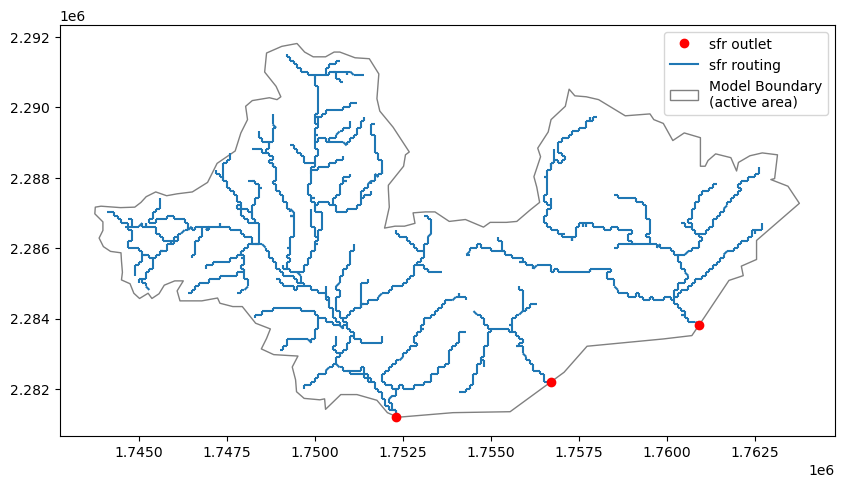

In [19]:
routing = gpd.read_file('shps/nhd_hr_demo_sfr_routing.shp')
outlets = gpd.read_file('shps/nhd_hr_demo_sfr_outlets.shp')
model_boundary_5070 = model_boundary.to_crs(crs=5070)

fig, ax = plt.subplots(figsize=(10,8))
routing.plot(ax=ax, zorder=1)
outlets.plot(ax=ax, c='red', zorder=2, label='outlets')
model_boundary_5070.plot(ax=ax, facecolor='None', 
                         edgecolor='gray',
                         zorder=0
                        ) 

LegendElement = [
    mpatches.mlines.Line2D([], [], color='red', linewidth=0., marker='o', label='sfr outlet'),
    mpatches.mlines.Line2D([], [], color='#1f77b4', label='sfr routing'),
    mpatches.Patch(facecolor='None', edgecolor='gray', label='Model Boundary\n(active area)')
]

ax.legend(handles=LegendElement, loc='best')
plt.show()